In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa
from librosa_ours import librosa as lib_ours
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [3]:
### define file names
fileOne = "audio_data/Chopin_Mazurka_Op30_No2_1_mono.wav"
fileTwo = "audio_data/Chopin_Mazurka_Op30_No2_2_mono.wav"

In [4]:
### read in the two wav files
freqOne, audioOne = wavfile.read(fileOne)
freqTwo, audioTwo = wavfile.read(fileTwo)
audioOne = audioOne.astype(float)
audioTwo = audioTwo.astype(float)

/Users/cstrong/anaconda/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
### generate chroma features from the audio data
hopLength = 4096 # 4096 * (1/44100 s/sample) = 9.3ms
nFFT = 32768 # 32768 * (1/44100 s/sample) = 74 ms
featuresOne = librosa.feature.chroma_stft(y = audioOne, sr = freqOne, hop_length = hopLength)
featuresTwo = librosa.feature.chroma_stft(y = audioTwo, sr = freqTwo, hop_length = hopLength)

In [6]:
### normalize the chroma features by their L2 norm in each column
featuresOne = librosa.util.normalize(featuresOne, norm=2, axis=0)
featuresTwo = librosa.util.normalize(featuresTwo, norm=2, axis=0)

In [7]:
###  setup DTW parameters
stepSizes = np.array([[1,1], [1, 2], [2, 1]])
weights = np.array([2, 3, 3])

In [8]:
### Run normal DTW
accumCostNormal, warpingPathNormal = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=False)

In [9]:
### Run our look-forward DTW
accumCostForward, warpingPathForward = lib_ours.sequence.dtw(featuresOne, featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, forward_update=True)

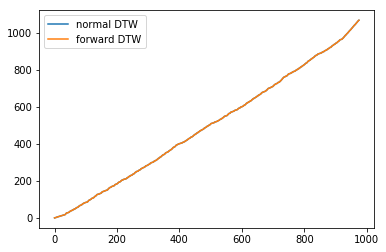

In [10]:
### Visualize both paths
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')
plt.plot([x for x, y in warpingPathForward], [y for x, y in warpingPathForward], label='forward DTW')
plt.legend()

In [11]:
### run subsequence DTW with each chunk, then plot in the correct location
def subsequenceDTWOnChunks(chunks):
    ###  setup DTW parameters
    stepSizes = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([1,1,2])

    bestWarpingPaths = []
    accumCosts = [] # array of accumulated cost matrices
    warpingPaths = [] # array where each subarray contains the warping paths for a given chunk
    
    for chunkIndex in range(len(chunks)):
        accumCostChunk, bestWarpingPathChunk, stepMatrix = lib_ours.sequence.dtw(chunks[chunkIndex], featuresTwo, metric='cosine', step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True, forward_update=True)
        accumCosts.append(accumCostChunk)
        
        # adjust the best warping path to account for the chunk being in the middle of the piece
        adjustAmount = np.sum([x.shape[1] for x in chunks[:chunkIndex]])
        adjustedBestWarpingPath = [(row+adjustAmount,col) for (row,col) in bestWarpingPathChunk]
        bestWarpingPaths.append(adjustedBestWarpingPath)
        
        # find each of the warping paths for this chunk
        warpingPathsForChunk = []

        for lastFrameIndex in range(accumCosts[0].shape[1]):
            curWarpingPath = lib_ours.sequence.__dtw_backtracking(stepMatrix[:, :(lastFrameIndex+1)], stepSizes)
            adjustedCurWarpingPath = [(row+adjustAmount,col) for (row,col) in curWarpingPath]
            warpingPathsForChunk.append(adjustedCurWarpingPath)
        warpingPaths.append(warpingPathsForChunk)
        
            
    return bestWarpingPaths, accumCosts, warpingPaths

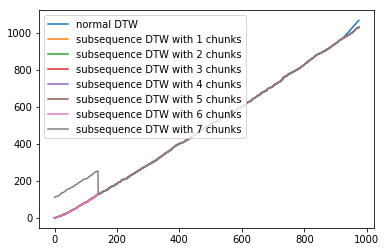

In [12]:
### split featuresOne into numChunks sub chunks
plt.figure(0)
plt.plot([x for x, y in warpingPathNormal], [y for x, y in warpingPathNormal], label='normal DTW')

for numChunks in range(1,8):
    plt.figure(0)
    chunks = np.array_split(featuresOne, numChunks, 1)
    bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)
    plt.plot([x for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], [y for chunkPath in bestWarpingPaths[::-1] for x, y in chunkPath], label='subsequence DTW with {} chunks'.format(numChunks))
    plt.legend()
    
    '''
    # plot the warping paths for the first chunk
    plt.figure()
    for warpingPath in warpingPaths[-1]:
        plt.plot([x for x, y in warpingPath], [y for x, y in warpingPath])
    ''' 
    
plt.legend()

In [19]:
### run subsequence DTW on each chunk, get back all the needed warping paths, and the accumulated cost matrix
numChunks = 3
chunks = np.array_split(featuresOne, numChunks, 1)

bestWarpingPaths, accumCosts, warpingPaths = subsequenceDTWOnChunks(chunks)

In [32]:
### Pull out the last frame from each subsequence cost matrix and put into a new matrix
print(accumCosts[0].shape)
lastCosts = np.zeros((len(accumCosts), accumCosts[0].shape[1]))

for chunkIndex in range(len(accumCosts)):
    lastCosts[chunkIndex,:] = accumCosts[chunkIndex][-1,:]
    
lastCosts[lastCosts==np.inf] = 9223372036854775807

stepSizes = np.array([1,0,0,1]).reshape((-1,2))
weights = np.array([1,0])

D, wp, stepMatrix = lib_ours.sequence.dtw(C=lastCosts, step_sizes_sigma = stepSizes, weights_mul = weights, subseq=True, return_steps=True)

firstStepMatrix = stepMatrix[0,:]
firstStep = np.argwhere(firstStepMatrix!=-1)[0][0]
firstStep = firstStep - 1 # the real first step won't have a backtrace


(326, 1068)
[[   2 1029]
 [   1 1029]
 [   1 1028]
 [   1 1027]
 [   1 1026]
 [   1 1025]
 [   1 1024]
 [   1 1023]
 [   1 1022]
 [   1 1021]
 [   1 1020]
 [   1 1019]
 [   1 1018]
 [   1 1017]
 [   1 1016]
 [   1 1015]
 [   1 1014]
 [   1 1013]
 [   1 1012]
 [   1 1011]
 [   1 1010]
 [   1 1009]
 [   1 1008]
 [   1 1007]
 [   1 1006]
 [   1 1005]
 [   1 1004]
 [   1 1003]
 [   1 1002]
 [   1 1001]
 [   1 1000]
 [   1  999]
 [   1  998]
 [   1  997]
 [   1  996]
 [   1  995]
 [   1  994]
 [   1  993]
 [   1  992]
 [   1  991]
 [   1  990]
 [   1  989]
 [   1  988]
 [   1  987]
 [   1  986]
 [   1  985]
 [   1  984]
 [   1  983]
 [   1  982]
 [   1  981]
 [   1  980]
 [   1  979]
 [   1  978]
 [   1  977]
 [   1  976]
 [   1  975]
 [   1  974]
 [   1  973]
 [   1  972]
 [   1  971]
 [   1  970]
 [   1  969]
 [   1  968]
 [   1  967]
 [   1  966]
 [   1  965]
 [   1  964]
 [   1  963]
 [   1  962]
 [   1  961]
 [   1  960]
 [   1  959]
 [   1  958]
 [   1  957]
 [   1  956]
 [   1  955]
